In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from math import *
import warnings
# warnings.filterwarnings('ignore')

In [2]:
# source after scraping, shown in the data/raw folder
df = pd.read_csv('../data/raw/realestate.csv')

In [3]:
df.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,furnished,latitude,longitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,$560 per week,Apartment,2,1,0,0,N,-37.80768181,144.96683064
1,435045047,2108/11 Rose Lane,Melbourne,3000,$580 per week,Apartment,2,1,0,0,Y,-37.81545214,144.95408105
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,$450 per week,Apartment,1,1,0,0,N,-37.80753655,144.96732789
3,435144711,300/668 Bourke Street,Melbourne,3000,$550 per week,Apartment,2,2,1,0,N,-37.8166019,144.95420038
4,435044255,2108/11 Rose Lane,Melbourne,3000,$600 per week,Apartment,2,1,0,0,Y,-37.81545214,144.95408105


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11143 entries, 0 to 11142
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             11143 non-null  int64 
 1   address        11095 non-null  object
 2   suburb         11143 non-null  object
 3   postcode       11143 non-null  int64 
 4   price          11143 non-null  object
 5   propertyType   11143 non-null  object
 6   bedrooms       11143 non-null  int64 
 7   bathrooms      11143 non-null  int64 
 8   parkingSpaces  11143 non-null  int64 
 9   studies        11143 non-null  int64 
 10  furnished      11143 non-null  object
 11  latitude       11143 non-null  object
 12  longitude      11143 non-null  object
dtypes: int64(6), object(7)
memory usage: 1.1+ MB


In [5]:
df.shape

(11143, 13)

In [6]:
# check 'id' for dublicate data
df.duplicated('id').sum()

10

In [7]:
df.drop_duplicates('id', inplace=True)
df.shape

(11133, 13)

In [8]:
df.isnull().sum()

id                0
address          48
suburb            0
postcode          0
price             0
propertyType      0
bedrooms          0
bathrooms         0
parkingSpaces     0
studies           0
furnished         0
latitude          0
longitude         0
dtype: int64

In [9]:
# address - 48 items missing, remove
df = df.dropna()

In [10]:
df.shape

(11085, 13)

In [11]:
# latitude and longitude have missing values and shown by 'none'; remove
df = df.drop(df[(df['latitude'] == 'None') | (df['longitude'] == 'None')].index)
df.shape

(11001, 13)

In [12]:
# process with regular expressions 
def fun(txt):
    txt = txt.lower() #Change Uppercase to Lower case 
    txt = re.sub(' ', '',txt)  # remove spaces 
    txt = re.sub(',', '',txt)  # remove comma ','，some numbers like 1,200, the comma needs to be removed for matching
    txt = re.sub('\.(\d+)', '', txt)  # process price data, remove decimal places - 250.00-->250
    txt = re.sub('\.', '', txt)  # remove'.'，p.w. also refers to perweek
    res = re.findall('/w|p/?w|week', txt)  # extract key words like perweek,/week,week,pw,/pw,p/w...
    
    # no matching string containing key words like perweek,/week... (not containing matching words)
    if len(res) == 0: 
        return 0
    
    rent = re.findall('\$(\d+)', txt)  # Extract the rental amount, which may contain both weekly and monthly rents, and return a matching string
    
    # if no matching string is returned, then there is no rent data in the certain price; fill it with zeros for now. （not containing rent data不含租金数据）
    if len(rent) == 0:
        return 0
    
    # take the minimum value when having both weekly rent and monthly rent
    rent = [int(rent[i]) for i in range(len(rent))]
    return min(rent)

In [13]:
df['price'] = df['price'].apply(fun)

In [14]:
# remove the data whose week rent is lower than $150 and over $2000
df_new = df[(df['price'] >= 150) & (df['price'] <= 2000)]
df_new['price'].describe()

count    10428.000000
mean       519.573168
std        211.443684
min        150.000000
25%        400.000000
50%        465.000000
75%        590.000000
max       2000.000000
Name: price, dtype: float64

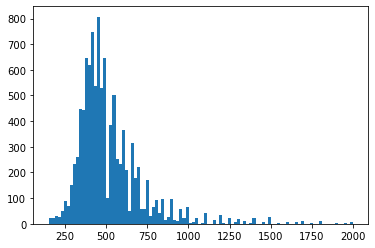

In [404]:
plt.hist(df_new['price'], bins = 100)
plt.show()

In [519]:
# Source from: data/raw/SchoolLocations2022_remove_non_relevant.csv
df_school = pd.read_csv('../data/raw/SchoolLocations2022_remove_non_relevant.csv', encoding = 'latin-1')
df_school.head()

,Education_Sector,Entity_Type,SCHOOL_NO,School_Name,School_Type,School_Status,Address_Line_1,Address_Line_2,Address_Town,Address_State,...,Postal_Address_Line_1,Postal_Address_Line_2,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,LGA_ID,LGA_Name,X,Y
0,Government,1,1,Alberton Primary School,Primary,O,21 Thomson Street,NaN,Alberton,VIC,...,21 Thomson Street,NaN,ALBERTON,VIC,3971,03 5183 2412,681,Wellington (S),146.66660,-38.61771
1,Government,1,3,Allansford and District Primary School,Primary,O,Frank Street,NaN,Allansford,VIC,...,Frank Street,NaN,ALLANSFORD,VIC,3277,03 5565 1382,673,Warrnambool (C),142.59039,-38.38628
2,Government,1,4,Avoca Primary School,Primary,O,118 Barnett Street,NaN,Avoca,VIC,...,P O Box 12,NaN,AVOCA,VIC,3467,03 5465 3176,599,Pyrenees (S),143.47565,-37.08450
3,Government,1,8,Avenel Primary School,Primary,O,40 Anderson Street,NaN,Avenel,VIC,...,40 Anderson Street,NaN,AVENEL,VIC,3664,03 5796 2264,643,Strathbogie (S),145.23472,-36.90137
4,Government,1,12,Warrandyte Primary School,Primary,O,5-11 Forbes Street,NaN,Warrandyte,VIC,...,5-11 Forbes Street,NaN,WARRANDYTE,VIC,3113,03 9844 3537,421,Manningham (C),145.21398,-37.74268


In [ ]:
df_school

,Education_Sector,Entity_Type,SCHOOL_NO,School_Name,School_Type,School_Status,Address_Line_1,Address_Line_2,Address_Town,Address_State,...,Postal_Address_Line_1,Postal_Address_Line_2,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,LGA_ID,LGA_Name,X,Y
0,Government,1,1,Alberton Primary School,Primary,O,21 Thomson Street,NaN,Alberton,VIC,...,21 Thomson Street,NaN,ALBERTON,VIC,3971,03 5183 2412,681,Wellington (S),146.66660,-38.61771
1,Government,1,3,Allansford and District Primary School,Primary,O,Frank Street,NaN,Allansford,VIC,...,Frank Street,NaN,ALLANSFORD,VIC,3277,03 5565 1382,673,Warrnambool (C),142.59039,-38.38628
2,Government,1,4,Avoca Primary School,Primary,O,118 Barnett Street,NaN,Avoca,VIC,...,P O Box 12,NaN,AVOCA,VIC,3467,03 5465 3176,599,Pyrenees (S),143.47565,-37.08450
3,Government,1,8,Avenel Primary School,Primary,O,40 Anderson Street,NaN,Avenel,VIC,...,40 Anderson Street,NaN,AVENEL,VIC,3664,03 5796 2264,643,Strathbogie (S),145.23472,-36.90137
4,Government,1,12,Warrandyte Primary School,Primary,O,5-11 Forbes Street,NaN,Warrandyte,VIC,...,5-11 Forbes Street,NaN,WARRANDYTE,VIC,3113,03 9844 3537,421,Manningham (C),145.21398,-37.74268


In [505]:
df_school['School_Type'].value_counts()

Primary      1140
Secondary     249
Special        89
Pri/Sec        81
Language        4
Camp            2
Name: School_Type, dtype: int64

In [506]:
df_school.duplicated().sum()

0

In [520]:
house_loc = df_new[['latitude', 'longitude']].astype('float64')
sch_loc = df_school[['School_Name', 'School_Type', 'Y', 'X']]  
sch_loc.isnull().sum()

School_Name    0
School_Type    0
Y              0
X              0
dtype: int64

In [521]:
sch_loc = sch_loc.dropna()

In [522]:
sch_loc['School_Type'].value_counts()

Primary      1140
Secondary     249
Special        89
Pri/Sec        81
Language        4
Camp            2
Name: School_Type, dtype: int64

In [523]:
pri_loc = sch_loc[(sch_loc['School_Type'] == 'Primary') | (sch_loc['School_Type'] == 'Pri/Sec')]
sec_loc = sch_loc[(sch_loc['School_Type'] == 'Secondary') | (sch_loc['School_Type'] == 'Pri/Sec')]
other_loc = sch_loc[(sch_loc['School_Type'] == 'Special') | (sch_loc['School_Type'] == 'Language') | (sch_loc['School_Type'] == 'Camp')]

In [524]:
def dist_fun(pos1, pos2):
    """
    dist_fun
    :param pos1: coordinates of the house in this case
    :param pos2: coordinates of school, train stations and tram stops and etc.
    """
    lon1, lat1, lon2, lat2 = map(radians, [pos1[1], pos1[0], pos2[1], pos2[0]])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371 
    dis = round((c * r * 1000) / 1000, 2)
    return dis

In [525]:
# pri_min_dist: minimal distance to primary school
pri_dist = cdist(house_loc, pri_loc[['Y', 'X']], metric = dist_fun)
pri_min_dist = pri_dist.min(axis = 1)

# sec_min_dist: minimal distance to secondary school
sec_dist = cdist(house_loc, sec_loc[['Y', 'X']], metric = dist_fun)
sec_min_dist = sec_dist.min(axis = 1)

# other_min_dist: minimal distance to other school: special,language,camp
other_dist = cdist(house_loc, other_loc[['Y', 'X']], metric = dist_fun)
other_min_dist = other_dist.min(axis = 1)

In [526]:
pd.Series(sec_min_dist)

0        1.56
1        1.70
2        1.57
3        1.59
4        1.70
         ... 
10422    3.90
10423    3.20
10424    1.30
10425    1.16
10426    2.12
Length: 10427, dtype: float64

In [ ]:
# To determine the name of the school. Take pri_dist as an example. Identify the nearest primary school.
# If needing more information, add a column name to ['School_Name'],
# adding the column for coordinates to acquire the specific value, ['School_Name'，'Y','X'].

In [533]:
# argmin returns the subscript index of the lowest value in each row or column and axis = 1 gives the horizontal direction.
pri_index = pri_dist.argmin(axis = 1)
pri_school_info = pri_loc.iloc[pri_index]
pri_school_info.head()

,School_Name,School_Type,Y,X
422,Carlton Gardens Primary School,Primary,-37.80205,144.96951
1218,Docklands Primary School,Primary,-37.81271,144.94055
422,Carlton Gardens Primary School,Primary,-37.80205,144.96951
1218,Docklands Primary School,Primary,-37.81271,144.94055
1218,Docklands Primary School,Primary,-37.81271,144.94055


In [534]:
sec_index = sec_dist.argmin(axis = 1)
sec_school_info = sec_loc.iloc[sec_index]
sec_school_info.head()

,School_Name,School_Type,Y,X
1414,University High School,Secondary,-37.79698,144.95538
1285,Victorian College Of The Arts Secondary School,Secondary,-37.82823,144.96477
1414,University High School,Secondary,-37.79698,144.95538
1285,Victorian College Of The Arts Secondary School,Secondary,-37.82823,144.96477
1285,Victorian College Of The Arts Secondary School,Secondary,-37.82823,144.96477


In [538]:
pd.Series(pri_min_dist)

0        0.67
1        1.23
2        0.64
3        1.27
4        1.23
         ... 
10422    1.04
10423    0.78
10424    2.92
10425    1.70
10426    0.26
Length: 10427, dtype: float64

In [539]:
pd.Series(sec_min_dist)

0        1.56
1        1.70
2        1.57
3        1.59
4        1.70
         ... 
10422    3.90
10423    3.20
10424    1.30
10425    1.16
10426    2.12
Length: 10427, dtype: float64

In [540]:
# pd.Series(other_min_dist)

In [543]:
df_new.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.97056,-37.81154,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.95442,-37.81289,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.97056,-37.81154,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.95442,-37.81289,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.95442,-37.81289,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786


In [565]:
df_new['min_pri_longitude'] = pri_school_info['X'].values
df_new['min_pri_latitude'] = pri_school_info['Y'].values

df_new['min_sec_longitude'] = sec_school_info['X'].values
df_new['min_sec_latitude'] = sec_school_info['Y'].values


In [545]:
df_new

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.96477,-37.82823,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11136,433277390,102-104 Ridge Road,Mount Dandenong,3767,750,House,3,2,6,0,...,145.34944,-37.86824,145.312402,-37.784749,145.181930,-37.856445,145.350727,-37.833291,145.355490,-37.832689
11138,434646035,A/25 Springs St,Cockatoo,3781,300,House,1,1,1,0,...,145.45874,-37.92427,145.355291,-37.909102,145.181930,-37.856445,145.487397,-37.936334,145.465820,-37.935276
11139,435115059,40 Fairway Rd,Emerald,3782,680,House,3,2,2,1,...,145.45874,-37.92427,145.355291,-37.909102,145.181930,-37.856445,145.469976,-37.921527,145.468303,-37.928784
11140,434812399,5 Florence Av,Emerald,3782,490,House,3,1,1,0,...,145.45874,-37.92427,145.355291,-37.909102,145.181930,-37.856445,145.445705,-37.927689,145.441522,-37.907092


In [546]:
import geopandas as gpd
path_train = r'../data/raw/PTV_METRO_TRAIN_STATION.shp'
# source of train stations: https://discover.data.vic.gov.au/dataset/ptv-metro-train-stations
path_tram = r'../data/raw/PTV_METRO_TRAM_STOP.shp'
# source of tram stops: https://discover.data.vic.gov.au/dataset/ptv-metro-tram-stops

In [547]:
gpd_train = gpd.read_file(path_train)
gpd_tram = gpd.read_file(path_tram)

In [548]:
gpd_train.head()

,STOP_ID,STOP_NAME,LATITUDE,LONGITUDE,TICKETZONE,ROUTEUSSP,geometry
0,19970,Royal Park Railway Station (Parkville),-37.781193,144.952301,1,Upfield,POINT (144.95231 -37.78118)
1,19971,Flemington Bridge Railway Station (North Melbo...,-37.788140,144.939323,1,Upfield,POINT (144.93933 -37.78813)
2,19972,Macaulay Railway Station (North Melbourne),-37.794267,144.936166,1,Upfield,POINT (144.93617 -37.79425)
3,19973,North Melbourne Railway Station (West Melbourne),-37.807419,144.942570,1,"Flemington,Sunbury,Upfield,Werribee,Williamsto...",POINT (144.94258 -37.80741)
4,19974,Clifton Hill Railway Station (Clifton Hill),-37.788657,144.995417,1,"Mernda,Hurstbridge",POINT (144.99542 -37.78864)


In [549]:
gpd_train = gpd_train[['STOP_NAME', 'STOP_ID', 'LATITUDE', 'LONGITUDE']]
gpd_train = pd.DataFrame(gpd_train)
gpd_train.head()

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
0,Royal Park Railway Station (Parkville),19970,-37.781193,144.952301
1,Flemington Bridge Railway Station (North Melbo...,19971,-37.788140,144.939323
2,Macaulay Railway Station (North Melbourne),19972,-37.794267,144.936166
3,North Melbourne Railway Station (West Melbourne),19973,-37.807419,144.942570
4,Clifton Hill Railway Station (Clifton Hill),19974,-37.788657,144.995417


In [550]:
gpd_train.duplicated('STOP_ID').sum()

0

In [551]:
train_dist = cdist(house_loc,gpd_train[['LATITUDE', 'LONGITUDE']], metric = dist_fun)
pd.Series(train_dist.min(axis = 1)).describe()

count    10427.000000
mean         1.488393
std          1.626153
min          0.020000
25%          0.500000
50%          0.930000
75%          1.810000
max         18.000000
dtype: float64

In [552]:
train_index = train_dist.argmin(axis = 1)

In [553]:
train = gpd_train[(gpd_train['STOP_ID'] != '')]
train_info = train.iloc[train_index][['STOP_NAME', 'STOP_ID', 'LATITUDE', 'LONGITUDE']]
train_info.head()

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
92,Melbourne Central Railway Station (Melbourne C...,19842,-37.809939,144.962594
63,Southern Cross Railway Station (Melbourne City),22180,-37.817936,144.951411
92,Melbourne Central Railway Station (Melbourne C...,19842,-37.809939,144.962594
63,Southern Cross Railway Station (Melbourne City),22180,-37.817936,144.951411
63,Southern Cross Railway Station (Melbourne City),22180,-37.817936,144.951411


In [554]:
train_longitude = gpd_train.iloc[train_index][['LONGITUDE']]
train_longitude.head()

,LONGITUDE
92,144.962594
63,144.951411
92,144.962594
63,144.951411
63,144.951411


In [555]:
train_latitude = gpd_train.iloc[train_index][['LATITUDE']]
train_latitude.head()

,LATITUDE
92,-37.809939
63,-37.817936
92,-37.809939
63,-37.817936
63,-37.817936


In [556]:
gpd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STOP_NAME  220 non-null    object 
 1   STOP_ID    220 non-null    object 
 2   LATITUDE   220 non-null    float64
 3   LONGITUDE  220 non-null    float64
dtypes: float64(2), object(2)
memory usage: 7.0+ KB


In [557]:
gpd_train.shape

(220, 4)

In [558]:
df_new['min_train_longitude'] = train_longitude.values
df_new['min_train_latitude'] = train_latitude.values

In [559]:
df_new.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.96477,-37.82823,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786


In [560]:
gpd_tram.head()

,STOP_ID,STOP_NAME,LATITUDE,LONGITUDE,TICKETZONE,ROUTEUSSP,geometry
0,18730,134-Merribell Ave/Nicholson St (Coburg),-37.744359,144.977728,1,1,POINT (144.97773 -37.74435)
1,18732,44-Deepdene Park/Whitehorse Rd (Balwyn),-37.811375,145.068671,1,109,POINT (145.06868 -37.81136)
2,18733,45-Hardwicke St/Whitehorse Rd (Balwyn),-37.811750,145.071785,1,109,POINT (145.07179 -37.81174)
3,18734,46-Balwyn Cinema/Whitehorse Rd (Balwyn),-37.812242,145.075930,1,109,POINT (145.07594 -37.81223)
4,18735,47-Balwyn Rd/Whitehorse Rd (Balwyn),-37.812919,145.081524,"1,2",109,POINT (145.08153 -37.81291)


In [561]:
gpd_tram = gpd_tram[['STOP_NAME', 'STOP_ID', 'LATITUDE', 'LONGITUDE']]
gpd_tram = pd.DataFrame(gpd_tram)
gpd_tram.head()

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
0,134-Merribell Ave/Nicholson St (Coburg),18730,-37.744359,144.977728
1,44-Deepdene Park/Whitehorse Rd (Balwyn),18732,-37.811375,145.068671
2,45-Hardwicke St/Whitehorse Rd (Balwyn),18733,-37.811750,145.071785
3,46-Balwyn Cinema/Whitehorse Rd (Balwyn),18734,-37.812242,145.075930
4,47-Balwyn Rd/Whitehorse Rd (Balwyn),18735,-37.812919,145.081524


In [562]:
gpd_tram.duplicated('STOP_ID').sum()

0

In [563]:
tram_dist = cdist(house_loc, gpd_tram[['LATITUDE', 'LONGITUDE']], metric = dist_fun)
pd.Series(tram_dist.min(axis = 1)).describe()

count    10427.000000
mean         4.431426
std          6.681865
min          0.010000
25%          0.180000
50%          0.890000
75%          6.010000
max         33.120000
dtype: float64

In [566]:
tram_index = tram_dist.argmin(axis = 1)

In [567]:
tram = gpd_tram[(gpd_tram['STOP_ID'] != '')]
tram_info = tram.iloc[tram_index][['STOP_NAME', 'STOP_ID', 'LATITUDE', 'LONGITUDE']]
tram_info.head()

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
548,7-Russell St/La Trobe St (Melbourne City),18047,-37.808909,144.966098
621,120-Lonsdale St/Spencer St (Melbourne City),18189,-37.815313,144.952381
549,8-Exhibition St/La Trobe St (Melbourne City),18048,-37.808185,144.968537
437,1-Spencer St/Bourke St (Melbourne City),17849,-37.816846,144.953997
621,120-Lonsdale St/Spencer St (Melbourne City),18189,-37.815313,144.952381


In [568]:
tram_longitude = gpd_tram.iloc[tram_index][['LONGITUDE']]
tram_longitude.head()

,LONGITUDE
548,144.966098
621,144.952381
549,144.968537
437,144.953997
621,144.952381


In [569]:
tram_latitude = gpd_tram.iloc[tram_index][['LATITUDE']]
tram_latitude.head()

,LATITUDE
548,-37.808909
621,-37.815313
549,-37.808185
437,-37.816846
621,-37.815313


In [570]:
gpd_tram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STOP_NAME  1665 non-null   object 
 1   STOP_ID    1665 non-null   object 
 2   LATITUDE   1665 non-null   float64
 3   LONGITUDE  1665 non-null   float64
dtypes: float64(2), object(2)
memory usage: 52.2+ KB


In [571]:
gpd_tram.shape

(1665, 4)

In [572]:
df_new['min_tram_longitude'] = tram_longitude.values
df_new['min_tram_latitude'] = tram_latitude.values

In [573]:
df_new.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.96477,-37.82823,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786


In [574]:
path_bus = r'../data/raw/PTV_METRO_BUS_STOP.shp'
# source of bus stops: https://discover.data.vic.gov.au/dataset/ptv-metro-bus-stops1

In [575]:
gpd_bus = gpd.read_file(path_bus)

In [576]:
gpd_bus.head()

,STOP_ID,STOP_NAME,LATITUDE,LONGITUDE,TICKETZONE,ROUTEUSSP,geometry
0,10185,Bonnie View Rd/Maroondah Hwy (Croydon North),-37.780920,145.288145,2,670,POINT (145.28815 -37.78091)
1,10186,Primrose Rd/Maroondah Hwy (Croydon North),-37.774626,145.292843,2,670,POINT (145.29285 -37.77461)
2,10187,Exeter Rd/Maroondah Hwy (Croydon North),-37.770446,145.295459,2,670,POINT (145.29546 -37.77043)
3,10188,Maroondah Golf Park/Maroondah Hwy (Chirnside P...,-37.766346,145.301775,2,670,POINT (145.30178 -37.76633)
4,10189,Old Melbourne Rd/Maroondah Hwy (Chirnside Park),-37.765276,145.304410,2,670,POINT (145.30442 -37.76526)


In [577]:
gpd_bus = gpd_bus[['STOP_NAME', 'STOP_ID', 'LATITUDE', 'LONGITUDE']]
gpd_bus = pd.DataFrame(gpd_bus)
gpd_bus

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
0,Bonnie View Rd/Maroondah Hwy (Croydon North),10185,-37.780920,145.288145
1,Primrose Rd/Maroondah Hwy (Croydon North),10186,-37.774626,145.292843
2,Exeter Rd/Maroondah Hwy (Croydon North),10187,-37.770446,145.295459
3,Maroondah Golf Park/Maroondah Hwy (Chirnside P...,10188,-37.766346,145.301775
4,Old Melbourne Rd/Maroondah Hwy (Chirnside Park),10189,-37.765276,145.304410
...,...,...,...,...
18554,Bambara Ct/Wright St (Sunshine West),47586,-37.794654,144.820117
18555,Booral Dr/Wright St (Sunshine West),47587,-37.794911,144.817452
18556,Fairbairn Rd/Wright St (Sunshine West),47588,-37.794707,144.817129
18557,Dalpura Dr/Wright St (Sunshine West),47589,-37.794700,144.811894


In [578]:
# the STOPs have been checked, the stops show the same name with according coordinates, thus; not necessary to remove. In case the IDs have potential uses.
gpd_bus.duplicated('STOP_ID').sum()

4

In [579]:
# if need to remove 
# gpd_bus = gpd_bus.drop_duplicates(subset = ['STOP_ID'], keep = 'first')

In [580]:
gpd_bus.loc[gpd_bus.duplicated('STOP_ID'), :]

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
13947,Mooroolbark Rd/Hull Rd (Mooroolbark),15694,-37.775096,145.330720
16729,Mooroolbark Rd/Hull Rd (Mooroolbark),16609,-37.774997,145.331971
16740,Mooroolbark Station/Brice Ave (Mooroolbark),21294,-37.784832,145.313184
16750,Lilydale Station/Maroondah Hwy (Lilydale),40196,-37.756251,145.347285


In [581]:
bus_dist = cdist(house_loc, gpd_bus[['LATITUDE', 'LONGITUDE']], metric = dist_fun)
pd.Series(bus_dist.min(axis = 1)).describe()

count    10427.000000
mean         0.247713
std          0.257379
min          0.010000
25%          0.100000
50%          0.180000
75%          0.300000
max          2.990000
dtype: float64

In [582]:
bus_index = bus_dist.argmin(axis = 1)

In [583]:
bus = gpd_bus[(gpd_bus['STOP_ID'] != '')]
bus_info = bus.iloc[bus_index][['STOP_NAME', 'STOP_ID', 'LATITUDE', 'LONGITUDE']]
bus_info.head()

,STOP_NAME,STOP_ID,LATITUDE,LONGITUDE
6469,Old Melbourne Gaol/Russell St (Melbourne City),19249,-37.807495,144.965637
6514,King St/Lonsdale St (Melbourne City),19549,-37.814288,144.955124
15827,Victoria St/Rathdowne St (Carlton),344,-37.806954,144.968752
6512,Lonsdale St/Spencer St (Melbourne City),19547,-37.814821,144.952077
6514,King St/Lonsdale St (Melbourne City),19549,-37.814288,144.955124


In [584]:
bus_longitude = gpd_bus.iloc[bus_index][['LONGITUDE']]
bus_longitude.head()

,LONGITUDE
6469,144.965637
6514,144.955124
15827,144.968752
6512,144.952077
6514,144.955124


In [585]:
bus_latitude = gpd_bus.iloc[bus_index][['LATITUDE']]
bus_latitude.head()

,LATITUDE
6469,-37.807495
6514,-37.814288
15827,-37.806954
6512,-37.814821
6514,-37.814288


In [586]:
gpd_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18559 entries, 0 to 18558
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STOP_NAME  18559 non-null  object 
 1   STOP_ID    18559 non-null  object 
 2   LATITUDE   18559 non-null  float64
 3   LONGITUDE  18559 non-null  float64
dtypes: float64(2), object(2)
memory usage: 580.1+ KB


In [587]:
gpd_bus.shape

(18559, 4)

In [588]:
df_new['min_bus_longitude'] = bus_longitude.values
df_new['min_bus_latitude'] = bus_latitude.values

In [589]:
df_new.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.96477,-37.82823,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786


In [590]:
path_park = r'../data/raw/PARKRES.shp'
# source of parks and conservation reserves: https://discover.data.vic.gov.au/dataset/parks-and-conservation-reserves-parkres

In [591]:
gpd_park = gpd.read_file(path_park)
gpd_park

,PRIMS_ID,NAME,NAME_SHORT,AREA_TYPE,TOTAL_AREA,AREA_SRC,MANAGER,VEAC_REC,VEAC_STUDY,IUCN,ESTAB_DATE,POLY_SRC,AREATYPEID,SRCHNAME,LAST_MOD,VERS_DATE,AREASQM,HECTARES,geometry
0,3284,River Murray Reserve,River Murray Reserve,NATURAL FEATURES RESERVE - RIVER MURRAY RESERVE,14968.432,GIS PARKRES,Parks Victoria,E1,Mallee Review (1989),VI,1986-09-30,HOLDING,16,RIVER MURRAY RESERVE,2021-01-05,2022-08-16,1.347108e+06,134.71,"POLYGON ((141.85471 -34.13201, 141.85469 -34.1..."
1,4995,Proposed Murray River Park (part),Proposed Murray River Park (part),OTHER,21951.232,GIS PARKRES,Parks Victoria,B3,River Red Gums Forests Investigation (2008),Not a Protected Area,None,HOLDING,25,PROPOSED MURRAY RIVER PARK (PART),2021-01-05,2022-08-16,2.359117e+06,235.91,"POLYGON ((141.83948 -34.13264, 141.83942 -34.1..."
2,4995,Proposed Murray River Park (part),Proposed Murray River Park (part),OTHER,21951.232,GIS PARKRES,Parks Victoria,B3,River Red Gums Forests Investigation (2008),Not a Protected Area,None,HOLDING,25,PROPOSED MURRAY RIVER PARK (PART),2021-01-05,2022-08-16,4.498651e+06,449.87,"POLYGON ((141.97451 -34.11443, 141.97463 -34.1..."
3,3320,Murray - Sunset National Park,Murray - Sunset NP,"NATIONAL PARK - SCHEDULE 2, NATIONAL PARKS ACT",666814.701,GIS PARKRES,Parks Victoria,A1,River Red Gums Forests Investigation (2008),II,1979-04-26,HOLDING,6,MURRAY - SUNSET NP NATIONAL PARK N.P.,2017-10-02,2022-08-16,3.319515e+08,33195.15,"POLYGON ((141.32267 -34.24596, 141.31919 -34.2..."
4,4995,Proposed Murray River Park (part),Proposed Murray River Park (part),OTHER,21951.232,GIS PARKRES,Parks Victoria,B3,River Red Gums Forests Investigation (2008),Not a Protected Area,None,HOLDING,25,PROPOSED MURRAY RIVER PARK (PART),2018-04-13,2022-08-16,8.112887e+04,8.11,"POLYGON ((142.01176 -34.12548, 142.01138 -34.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8587,4116,Flinders Jetty,Flinders Jetty,PORT & COASTAL FACILITY,0.582,GIS PARKRES,Parks Victoria as COM,-,No LCC Recommendation,Not a Protected Area,None,VM PARCEL EDITED WITH 25K FEATURES,50,FLINDERS JETTY,2012-07-11,2022-08-16,5.818810e+03,0.58,"POLYGON ((145.02563 -38.47558, 145.02563 -38.4..."
8588,276,Sweetwater Creek Nature Conservation Reserve,Sweetwater Creek NCR,NATURE CONSERVATION RESERVE,1201.242,GIS PARKRES,Parks Victoria,C9,Melbourne 2 Review (1994),Ia,1997-06-17,VM PARCEL EDITED WITH 25K FEATURES,20,SWEETWATER CREEK NCR NATURE CONSERVATION RESER...,2022-03-02,2022-08-16,1.201242e+07,1201.24,"POLYGON ((146.11148 -38.04297, 146.11284 -38.0..."
8589,3643,Avon-Perry River Delta Gippsland Lakes Reserve,Avon-Perry River Delta GLR,NATURAL FEATURES RESERVE - GIPPSLAND LAKES RES...,169.243,GIS PARKRES,Parks Victoria,A6,Gippsland Lakes Hinterland (1983),VI,1984-06-19,VM PARCEL EDITED WITH 25K FEATURES,12,AVON-PERRY RIVER DELTA GLR GIPPSLAND LAKES RES...,2012-07-11,2022-08-16,1.692437e+06,169.24,"POLYGON ((147.27961 -38.04118, 147.27955 -38.0..."
8590,3304,Budj Bim National Park,Budj Bim NP,"NATIONAL PARK - SCHEDULE 2, NATIONAL PARKS ACT",8571.392,GIS PARKRES,Parks Victoria,A8,South West 1 Review (1983),II,1960-06-07,HOLDING,6,BUDJ BIM NP NATIONAL PARK N.P.,2021-06-09,2022-08-16,8.405804e+07,8405.80,"POLYGON ((141.86880 -38.04019, 141.86880 -38.0..."


In [592]:
# gpd_park['AREA_TYPE'].value_counts()

In [593]:
gpd_park.duplicated().sum()

0

In [595]:
# Using DataFrame.drop_duplicates() to keep first duplicate row based on specific column - PRIMS_ID
gpd_park = gpd_park.drop_duplicates(subset = ['PRIMS_ID'], keep = 'first')

In [596]:
gpd_park

,PRIMS_ID,NAME,NAME_SHORT,AREA_TYPE,TOTAL_AREA,AREA_SRC,MANAGER,VEAC_REC,VEAC_STUDY,IUCN,ESTAB_DATE,POLY_SRC,AREATYPEID,SRCHNAME,LAST_MOD,VERS_DATE,AREASQM,HECTARES,geometry
0,3284,River Murray Reserve,River Murray Reserve,NATURAL FEATURES RESERVE - RIVER MURRAY RESERVE,14968.432,GIS PARKRES,Parks Victoria,E1,Mallee Review (1989),VI,1986-09-30,HOLDING,16,RIVER MURRAY RESERVE,2021-01-05,2022-08-16,1.347108e+06,134.71,"POLYGON ((141.85471 -34.13201, 141.85469 -34.1..."
1,4995,Proposed Murray River Park (part),Proposed Murray River Park (part),OTHER,21951.232,GIS PARKRES,Parks Victoria,B3,River Red Gums Forests Investigation (2008),Not a Protected Area,None,HOLDING,25,PROPOSED MURRAY RIVER PARK (PART),2021-01-05,2022-08-16,2.359117e+06,235.91,"POLYGON ((141.83948 -34.13264, 141.83942 -34.1..."
3,3320,Murray - Sunset National Park,Murray - Sunset NP,"NATIONAL PARK - SCHEDULE 2, NATIONAL PARKS ACT",666814.701,GIS PARKRES,Parks Victoria,A1,River Red Gums Forests Investigation (2008),II,1979-04-26,HOLDING,6,MURRAY - SUNSET NP NATIONAL PARK N.P.,2017-10-02,2022-08-16,3.319515e+08,33195.15,"POLYGON ((141.32267 -34.24596, 141.31919 -34.2..."
5,352,Yarrara Flora and Fauna Reserve,Yarrara FFR,NATURE CONSERVATION RESERVE - FLORA AND FAUNA ...,2267.804,GIS PARKRES,Parks Victoria,G1,Mallee Review (1989),Ia,1979-05-01,HOLDING,21,YARRARA FFR FLORA AND FAUNA RESERVE F.F.R.,2017-10-02,2022-08-16,1.258619e+04,1.26,"POLYGON ((141.42669 -34.40166, 141.42604 -34.4..."
6,1056,Bambill Bushland Reserve,Bambill BR,NATURAL FEATURES RESERVE - BUSHLAND RESERVE,50.838,GIS PARKRES,Parks Victoria,I2,Mallee Review (1989),IV,1979-05-01,VM PARCEL EDITED WITH 25K FEATURES,9,BAMBILL BR BUSHLAND RESERVE B.R.,2016-10-10,2022-08-16,2.999704e+04,3.00,"POLYGON ((141.50464 -34.40151, 141.50367 -34.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,1982,Bolwarra H43 Bushland Reserve,Bolwarra H43 BR,NATURAL FEATURES RESERVE - BUSHLAND RESERVE,24.429,GIS PARKRES,Parks Victoria,H43,South West 1 Review (1983),IV,1984-06-26,VM PARCEL EDITED WITH 25K FEATURES,9,BOLWARRA H43 BR BUSHLAND RESERVE B.R.,2012-07-11,2022-08-16,2.442929e+05,24.43,"POLYGON ((141.60593 -38.28568, 141.60294 -38.2..."
8583,1983,Bolwarra H44 Bushland Reserve,Bolwarra H44 BR,NATURAL FEATURES RESERVE - BUSHLAND RESERVE,119.701,GIS PARKRES,Parks Victoria,H44,South West 1 Review (1983),IV,1984-06-26,VM PARCEL EDITED WITH 25K FEATURES,9,BOLWARRA H44 BR BUSHLAND RESERVE B.R.,2012-07-11,2022-08-16,1.197013e+06,119.70,"POLYGON ((141.58790 -38.28575, 141.59926 -38.2..."
8587,4116,Flinders Jetty,Flinders Jetty,PORT & COASTAL FACILITY,0.582,GIS PARKRES,Parks Victoria as COM,-,No LCC Recommendation,Not a Protected Area,None,VM PARCEL EDITED WITH 25K FEATURES,50,FLINDERS JETTY,2012-07-11,2022-08-16,5.818810e+03,0.58,"POLYGON ((145.02563 -38.47558, 145.02563 -38.4..."
8588,276,Sweetwater Creek Nature Conservation Reserve,Sweetwater Creek NCR,NATURE CONSERVATION RESERVE,1201.242,GIS PARKRES,Parks Victoria,C9,Melbourne 2 Review (1994),Ia,1997-06-17,VM PARCEL EDITED WITH 25K FEATURES,20,SWEETWATER CREEK NCR NATURE CONSERVATION RESER...,2022-03-02,2022-08-16,1.201242e+07,1201.24,"POLYGON ((146.11148 -38.04297, 146.11284 -38.0..."


In [597]:
from shapely.geometry import Polygon, LineString, Point

gpd_park = gpd_park[['NAME', 'PRIMS_ID', 'geometry']]
gpd_park.head()

,NAME,PRIMS_ID,geometry
0,River Murray Reserve,3284,"POLYGON ((141.85471 -34.13201, 141.85469 -34.1..."
1,Proposed Murray River Park (part),4995,"POLYGON ((141.83948 -34.13264, 141.83942 -34.1..."
3,Murray - Sunset National Park,3320,"POLYGON ((141.32267 -34.24596, 141.31919 -34.2..."
5,Yarrara Flora and Fauna Reserve,352,"POLYGON ((141.42669 -34.40166, 141.42604 -34.4..."
6,Bambill Bushland Reserve,1056,"POLYGON ((141.50464 -34.40151, 141.50367 -34.4..."


In [598]:
gpd_park['Center_point'] = gpd_park['geometry'].centroid

In [599]:
gpd_park['Longitude'] = gpd_park.Center_point.map(lambda p: p.x)
gpd_park['Latitude'] = gpd_park.Center_point.map(lambda p: p.y)

In [600]:
gpd_park.head()

,NAME,PRIMS_ID,geometry,Center_point,Longitude,Latitude
0,River Murray Reserve,3284,"POLYGON ((141.85471 -34.13201, 141.85469 -34.1...",POINT (141.85452 -34.12772),141.854523,-34.127715
1,Proposed Murray River Park (part),4995,"POLYGON ((141.83948 -34.13264, 141.83942 -34.1...",POINT (141.80626 -34.12228),141.806262,-34.122281
3,Murray - Sunset National Park,3320,"POLYGON ((141.32267 -34.24596, 141.31919 -34.2...",POINT (141.11774 -34.21818),141.117737,-34.218176
5,Yarrara Flora and Fauna Reserve,352,"POLYGON ((141.42669 -34.40166, 141.42604 -34.4...",POINT (141.42637 -34.40066),141.426366,-34.400658
6,Bambill Bushland Reserve,1056,"POLYGON ((141.50464 -34.40151, 141.50367 -34.4...",POINT (141.50576 -34.40067),141.505757,-34.400670


In [601]:
gpd_park.duplicated('PRIMS_ID').sum()

0

In [602]:
park_dist = cdist(house_loc, gpd_park[['Latitude', 'Longitude']], metric = dist_fun)
pd.Series(park_dist.min(axis = 1)).describe()

count    10427.000000
mean         2.599126
std          1.482150
min          0.100000
25%          1.340000
50%          2.400000
75%          3.670000
max          8.090000
dtype: float64

In [603]:
park_index = park_dist.argmin(axis=1)

In [604]:
park = gpd_park[(gpd_park['NAME'] != '')]
park_info = park.iloc[park_index][['NAME', 'PRIMS_ID', 'Latitude', 'Longitude']]
park_info.head()

,NAME,PRIMS_ID,Latitude,Longitude
6170,Carlton Court House Historic Reserve,4352,-37.797682,144.968679
6128,Princes Warf,4238,-37.818786,144.969296
6170,Carlton Court House Historic Reserve,4352,-37.797682,144.968679
6128,Princes Warf,4238,-37.818786,144.969296
6128,Princes Warf,4238,-37.818786,144.969296


In [605]:
park_longitude = gpd_park.iloc[park_index][['Longitude']]
park_longitude.head()

,Longitude
6170,144.968679
6128,144.969296
6170,144.968679
6128,144.969296
6128,144.969296


In [606]:
park_latitude = gpd_park.iloc[park_index][['Latitude']]
park_latitude.head()

,Latitude
6170,-37.797682
6128,-37.818786
6170,-37.797682
6128,-37.818786
6128,-37.818786


In [607]:
gpd_park.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3436 entries, 0 to 8589
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   NAME          3436 non-null   object  
 1   PRIMS_ID      3436 non-null   int64   
 2   geometry      3436 non-null   geometry
 3   Center_point  3436 non-null   geometry
 4   Longitude     3436 non-null   float64 
 5   Latitude      3436 non-null   float64 
dtypes: float64(2), geometry(2), int64(1), object(1)
memory usage: 187.9+ KB


In [608]:
gpd_park.shape

(3436, 6)

In [609]:
df_new['min_park_longitude'] = park_longitude.values
df_new['min_park_latitude'] = park_latitude.values

In [610]:
df_new.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.96477,-37.82823,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786


In [611]:
df_new = df_new.drop(df_new[(df_new['suburb'] == 'Adelaide')].index)

In [612]:
df_new

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,...,min_sec_longitude,min_sec_latitude,min_train_longitude,min_train_latitude,min_tram_longitude,min_tram_latitude,min_bus_longitude,min_bus_latitude,min_park_longitude,min_park_latitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.966098,-37.808909,144.965637,-37.807495,144.968679,-37.797682
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,...,144.95538,-37.79698,144.962594,-37.809939,144.968537,-37.808185,144.968752,-37.806954,144.968679,-37.797682
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,...,144.96477,-37.82823,144.951411,-37.817936,144.953997,-37.816846,144.952077,-37.814821,144.969296,-37.818786
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,...,144.96477,-37.82823,144.951411,-37.817936,144.952381,-37.815313,144.955124,-37.814288,144.969296,-37.818786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11136,433277390,102-104 Ridge Road,Mount Dandenong,3767,750,House,3,2,6,0,...,145.34944,-37.86824,145.312402,-37.784749,145.181930,-37.856445,145.350727,-37.833291,145.355490,-37.832689
11138,434646035,A/25 Springs St,Cockatoo,3781,300,House,1,1,1,0,...,145.45874,-37.92427,145.355291,-37.909102,145.181930,-37.856445,145.487397,-37.936334,145.465820,-37.935276
11139,435115059,40 Fairway Rd,Emerald,3782,680,House,3,2,2,1,...,145.45874,-37.92427,145.355291,-37.909102,145.181930,-37.856445,145.469976,-37.921527,145.468303,-37.928784
11140,434812399,5 Florence Av,Emerald,3782,490,House,3,1,1,0,...,145.45874,-37.92427,145.355291,-37.909102,145.181930,-37.856445,145.445705,-37.927689,145.441522,-37.907092


In [15]:
df_new.to_csv('../data/curated/realestate_coor.csv',index = False)